In [1]:
import itertools

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

from nltk import bigrams
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

from datasets import Dataset, DatasetDict

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


In [2]:
import torch
torch.cuda.empty_cache() 

In [3]:
bib_verses = {}

for ve in F.otype.s('verse'):
    bo, ch, v = T.sectionFromNode(ve)
    heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in L.d(ve, 'word')]).strip()
    bib_verses[(bo, ch, v)] = [bo, ch, v, heb_text]

bib_df = pd.DataFrame(bib_verses).T
bib_df.columns = ['book', 'chapter', 'verse', 'text']
bib_df.head()



book chapter verse  \
Genesis 1 1  Genesis       1     1   
          2  Genesis       1     2   
          3  Genesis       1     3   
          4  Genesis       1     4   
          5  Genesis       1     5   

                                                          text  
Genesis 1 1               בראשׁית ברא אלהים את השׁמים ואת הארץ  
          2  והארץ היתה תהו ובהו וחשׁך על פני תהום ורוח אלה...  
          3                       ויאמר אלהים יהי אור ויהי אור  
          4  וירא אלהים את האור כי טוב ויבדל אלהים בין האור...  
          5  ויקרא אלהים לאור יום ולחשׁך קרא לילה ויהי ערב ...

In [4]:
def make_n_grams(input_list, n):
  return zip(*[input_list[i:] for i in range(n)])

def make_n_clause_dict(n):
    n_clause_dict = {}
    #bo_ch_list = []

    for bo in F.otype.s('book'):
        cl_n_grams = list(make_n_grams(L.d(bo, 'clause'), n))
        
        for cl_n_gram in cl_n_grams:
            ch = L.u(cl_n_gram[0], 'chapter')[0]
            book, chapter_number = T.sectionFromNode(ch)
            
            words_n_clause = sorted(list(itertools.chain(*[L.d(cl, 'word') for cl in cl_n_gram])))
            heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in words_n_clause]).strip()
            n_clause_dict[(book, chapter_number, cl_n_gram)] = [book, chapter_number, cl_n_gram, heb_text]

    return n_clause_dict

n_clause_dict = make_n_clause_dict(3)

bib_df = pd.DataFrame(n_clause_dict).T
bib_df.columns = ['book', 'chapter', 'clauses', 'text']
bib_df.head()

book chapter                   clauses  \
Genesis 1 (427559, 427560, 427561)  Genesis       1  (427559, 427560, 427561)   
          (427560, 427561, 427562)  Genesis       1  (427560, 427561, 427562)   
          (427561, 427562, 427563)  Genesis       1  (427561, 427562, 427563)   
          (427562, 427563, 427564)  Genesis       1  (427562, 427563, 427564)   
          (427563, 427564, 427565)  Genesis       1  (427563, 427564, 427565)   

                                                                                 text  
Genesis 1 (427559, 427560, 427561)  בראשׁית ברא אלהים את השׁמים ואת הארץ והארץ הית...  
          (427560, 427561, 427562)  והארץ היתה תהו ובהו וחשׁך על פני תהום ורוח אלה...  
          (427561, 427562, 427563)  וחשׁך על פני תהום ורוח אלהים מרחפת על פני המים...  
          (427562, 427563, 427564)   ורוח אלהים מרחפת על פני המים ויאמר אלהים יהי אור  
          (427563, 427564, 427565)                       ויאמר אלהים יהי אור ויהי אור

In [5]:
bib_ds = Dataset.from_pandas(bib_df)

In [6]:
tokenizer = AutoTokenizer.from_pretrained('dicta-il/BEREL')

In [7]:
def tokenize(sentence):
  return tokenizer(sentence['text'], max_length=128, truncation=True, padding=True)

tokenized_data = bib_ds.map(tokenize, batched=True) #, remove_columns=raw_data['train'].column_names)
tokenized_data.set_format("pt", columns=["input_ids", "attention_mask"], output_all_columns=True)

tokenized_data = tokenized_data.train_test_split(test_size=0.2)

Map:   0%|          | 0/88053 [00:00<?, ? examples/s]

In [8]:
model = BertForMaskedLM.from_pretrained('dicta-il/BEREL', output_hidden_states=True)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\transformers\generation\configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to

In [9]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=True, mlm_probability=.15)

In [21]:
args = TrainingArguments(output_dir="martijn75/berel_finetuned_on_HB_2_epochs_general", 
                         evaluation_strategy="steps",
                         save_strategy="epoch",
                         learning_rate=0.0005,
                         num_train_epochs=2,
                         per_device_train_batch_size=8, 
                         per_device_eval_batch_size=8,
                         seed=42,
                        )
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
  )

trainer.train()

trainer.push_to_hub()

C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\geitb\AppData\Local\Temp\ipykernel_20272\473025254.py:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
500,7.956100,8.714962
1000,8.734300,8.722939
1500,8.640300,8.690545
2000,8.676000,8.674800
2500,8.625300,8.682088
3000,8.710900,8.682266
3500,8.664600,8.649789
4000,8.604500,8.645757
4500,8.674400,8.637487
5000,8.659500,8.631009


model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/martijn75/berel_finetuned_on_HB_2_epochs_general/commit/b36e119505cde381f661e65db19f1d28256ef51a', commit_message='End of training', commit_description='', oid='b36e119505cde381f661e65db19f1d28256ef51a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/martijn75/berel_finetuned_on_HB_2_epochs_general', endpoint='https://huggingface.co', repo_type='model', repo_id='martijn75/berel_finetuned_on_HB_2_epochs_general'), pr_revision=None, pr_num=None)

In [8]:
prose = {
    'Genesis',
    'Exodus',
    'Leviticus',
    'Numbers',
    'Deuteronomy',
    'Joshua',
    'Judges',
    '1_Samuel',
    '2_Samuel',
    '1_Kings',
    '2_Kings',
    'Ruth',
    'Esther',
    'Daniel',
    'Ezra',
    'Nehemiah',
    '1_Chronicles',
    '2_Chronicles'
        }

poetry = {
    'Psalms',
    'Job',
    'Proverbs',
    'Song_of_songs',
    'Ecclesiastes',
    'Lamentations'
}

jeremiah = {'Jeremiah'}

genre_dict = {}
for book in prose:
    genre_dict[book] = 'prose'
for book in poetry:
    genre_dict[book] = 'poetry'

genre_dict['Jeremiah'] = 'Jeremiah'

In [23]:
bi_clause_genre_dict = {}

for bo in F.otype.s('book'):
    book = T.sectionFromNode(bo)[0]
    #if book not in genre_dict:
    #    continue
    
    cl_bigrams = list(bigrams(L.d(bo, 'clause')))

    for cl_bigram in cl_bigrams:
        words_bi_clause = sorted(list(itertools.chain(*[L.d(cl, 'word') for cl in cl_bigram])))
        heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in words_bi_clause]).strip()
        bi_clause_genre_dict[(book, cl_bigram, genre_dict.get(book))] = heb_text    

del A, F, T, L

In [24]:
len(bi_clause_genre_dict)

72202

In [9]:
def get_last_hidden_state(model, inputs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #'cpu' 
    model = model.to(device)
    outputs = model(**inputs)
    return outputs

In [10]:
def split_evenly(l, n):
    len_ = len(l)
    split_size = len_ // n
    split_size = n if not split_size else split_size
    offsets = [i for i in range(0, len_, split_size)]
    return [l[offset:offset + split_size] for offset in offsets]

In [11]:
heb_texts = list(n_clause_dict.values())
heb_texts_n = split_evenly(heb_texts, 1000)

In [12]:
len(heb_texts_n)

1001

In [ ]:
heb_texts_n

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#tokenizer = AutoTokenizer.from_pretrained('dicta-il/BEREL')
#model = BertForMaskedLM.from_pretrained('dicta-il/BEREL', output_hidden_states=True).to(device)

model = BertForMaskedLM.from_pretrained('martijn75/berel_finetuned_on_HB_2_epochs_general', 
                                                           ).to(device)
model.eval()

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\transformers\generation\configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementw

In [14]:
hidden_states = []

for idx, texts_chunk in enumerate(heb_texts_n):
    tokenized_inputs = tokenizer(texts_chunk, max_length=128, truncation=True, padding=True, return_tensors="pt")
    tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
    with torch.no_grad():
        outputs = get_last_hidden_state(model, tokenized_inputs)
        last_hidden_states = outputs.hidden_states[-1].cpu().numpy()
        hidden_states.append(last_hidden_states)

TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [31]:
hidden_states_mean = []

for hs in hidden_states:

    bi_clause_states= np.mean(hs, 1)
    hidden_states_mean.append(bi_clause_states)

all_embeddings = np.concatenate(hidden_states_mean, axis=0)

In [32]:
all_genres = []
all_labels = []

for bo, clauses, genre in bi_clause_genre_dict.keys():
    if genre == 'prose':
        all_genres.append(0)
    elif genre == 'poetry':
        all_genres.append(1)
    elif genre == 'Jeremiah':
        all_genres.append(2)

    all_labels.append((bo, clauses))

In [33]:
print(len(all_genres), len(all_embeddings))

72202 72202


In [34]:
pr_po_idx = [idx for idx, value in enumerate(all_genres) if value != 2]
y = np.array([value for idx, value in enumerate(all_genres) if value != 2])

prose_poetry_embeddings = all_embeddings[pr_po_idx,:]
jer_embeddings = np.delete(all_embeddings, pr_po_idx, axis=0)

prose_poetry_labels = [label for genre, label in zip(all_genres, all_labels) if genre != 2]

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(prose_poetry_embeddings, y, test_size=0.2)

In [37]:
X_train = pd.DataFrame(X_train)
X_train['label'] = y_train

poetry = X_train[X_train.label == 1]
print(poetry.shape)
prose = X_train[X_train.label == 0]
print(prose.shape)

(11697, 769)
(41126, 769)


In [38]:
from sklearn.utils import resample

poetry_upsample = resample(poetry,
             replace=True,
             n_samples=len(prose),
             random_state=42)

all_upsampled = pd.concat([poetry_upsample, prose])
print(all_upsampled.shape, pd.value_counts(all_upsampled.label))

X_train = all_upsampled.drop('label', axis=1)
y_train = all_upsampled['label']

(82252, 769) label
1    41126
0    41126
Name: count, dtype: int64


C:\Users\geitb\AppData\Local\Temp\ipykernel_20272\3847905214.py:9: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(all_upsampled.shape, pd.value_counts(all_upsampled.label))


In [39]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [40]:
y_pred = rf.predict(X_test)

In [41]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8774042102074815


In [42]:
pd.crosstab(y_test, y_pred)

col_0,0,1
row_0,,
0,9533,790
1,829,2054


In [43]:
jer_preds = list((rf.predict(jer_embeddings)))
#jer_preds

### PCA

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA, FastICA, NMF, FactorAnalysis

In [45]:
random_state = 0
pca_pl = make_pipeline(
    StandardScaler(),
    PCA(n_components = 6,
        random_state = random_state)
)

In [46]:
pcs = pca_pl.fit_transform(prose_poetry_embeddings)

In [47]:
pcs

array([[ -0.19844195,  -2.1809661 ,  39.03529   ,  -7.4504886 ,
         -0.76295257,  -0.14142911],
       [ -0.44287613,  -1.5574945 ,  38.454514  ,  -6.485436  ,
         -1.2430128 ,  -0.14821284],
       [ -0.46459863,  -2.369609  ,  39.15214   ,  -7.0795026 ,
         -1.7520901 ,  -0.3475547 ],
       ...,
       [ -7.126169  , -16.916433  ,  -0.2604573 ,   2.62488   ,
          3.3293908 ,  -3.5049567 ],
       [ -6.4988937 , -17.073519  ,  -0.99578226,   2.2166378 ,
          3.2814698 ,  -3.5857947 ],
       [ -6.7983704 , -16.35923   ,  -0.2105493 ,   2.382442  ,
          3.1067753 ,  -3.1403034 ]], dtype=float32)

In [48]:
pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y



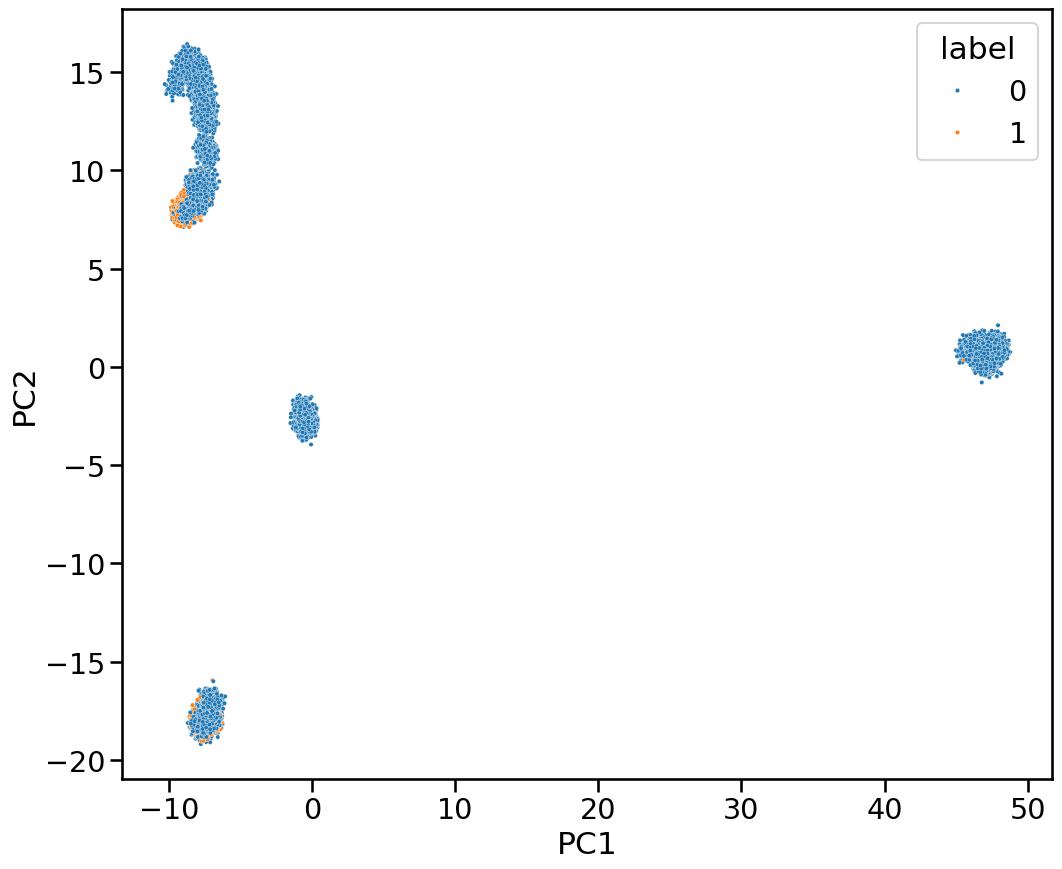

In [49]:
comp1 = 'PC1'
comp2 = 'PC2'


pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y
pcs_df['book'] = prose_poetry_labels

plt.figure(figsize=(12,10))
with sns.plotting_context("talk",font_scale=1.25):
    sns.scatterplot(x=comp1, y=comp2,
                    data=pcs_df, 
                    hue="label",
                    s=10)
    plt.xlabel(comp1)
    plt.ylabel(comp2)
   
#plt.savefig("pca_chb_lbh_jer.png",
#                    format='png',dpi=150)

In [50]:
from sklearn.cluster import KMeans

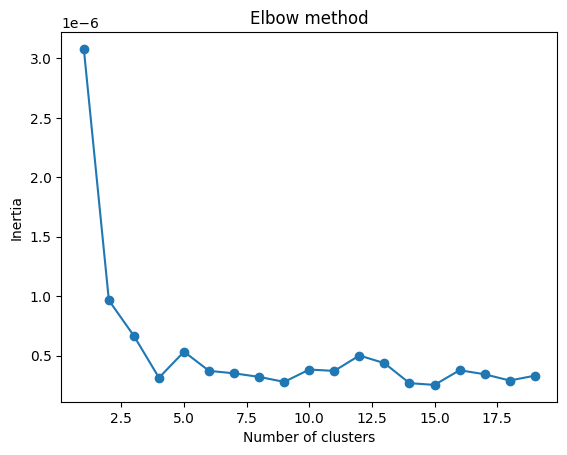

In [51]:
inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(prose_poetry_embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [52]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(prose_poetry_embeddings)

KMeans(n_clusters=4)

In [53]:
kmeans.labels_

array([3, 3, 3, ..., 2, 2, 2])

In [54]:
import collections

collections.Counter([(bo, label) for (bo, cl), label in zip(prose_poetry_labels, kmeans.labels_)])

Counter({('Psalms', 0): 5556,
         ('Genesis', 0): 2880,
         ('Job', 0): 2338,
         ('1_Samuel', 2): 2180,
         ('Proverbs', 0): 1976,
         ('Exodus', 0): 1887,
         ('Genesis', 2): 1882,
         ('1_Chronicles', 0): 1783,
         ('Psalms', 2): 1728,
         ('Deuteronomy', 0): 1626,
         ('Numbers', 0): 1622,
         ('2_Kings', 0): 1557,
         ('Joshua', 0): 1504,
         ('Exodus', 2): 1502,
         ('2_Samuel', 2): 1420,
         ('2_Samuel', 0): 1404,
         ('1_Kings', 2): 1398,
         ('2_Chronicles', 0): 1313,
         ('1_Samuel', 0): 1296,
         ('Leviticus', 0): 1209,
         ('1_Kings', 0): 1188,
         ('Deuteronomy', 2): 1152,
         ('Judges', 0): 1152,
         ('Leviticus', 2): 1080,
         ('Numbers', 1): 1014,
         ('Judges', 2): 1008,
         ('2_Chronicles', 2): 994,
         ('Genesis', 1): 936,
         ('Nehemiah', 0): 870,
         ('2_Kings', 2): 834,
         ('Daniel', 0): 827,
         ('Deuteronomy'

In [55]:
pcs_df_km = pcs_df.drop(['PC3', 'PC4','PC5','PC6','label'], axis=1)

km = KMeans(n_clusters=20)
km.fit(pcs_df_km)

ValueError: setting an array element with a sequence.

In [56]:
km_df = pd.DataFrame([(bo, label) for (bo, cl), label in zip(prose_poetry_labels, km.labels_)])
km_df.columns = ['book', 'cl']
pd.crosstab(km_df.book, km_df.cl)

AttributeError: 'KMeans' object has no attribute 'labels_'

In [57]:
inertias = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(pcs_df_km)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

ValueError: setting an array element with a sequence.

In [45]:
dir(kmeans)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_tags__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_algorithm',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_mkl_vcomp',
 '_check_n_features',
 '_check_params_vs_input',
 '_check_test_data',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_init_centroids',
 '_more_tags',
 '_n_features_out',
 '_n_init',
 '_n_threads',
 '_parameter_constraints',
 '_re